In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

from get_loader_v2_train_val_test import get_train_loader, get_val_test_loader, get_length_vocab, get_pad_index, get_vocab, show_image
from get_loader_v2_train_val_test import Vocabulary
from get_loader_v2_train_val_test import Dataset

from train_and_val import train, validate

from models.models import  EncoderDecoder

import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


In [2]:
data_dir = 'data/Images/'
captions_file = 'data/captions.txt'

transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()])

# Split data into train and test sets
df_captions = pd.read_csv(captions_file)
unique_images = df_captions['image'].unique()
train_images, test_images = train_test_split(unique_images, test_size=0.2, random_state=42)
train_images, val_images = train_test_split(train_images, test_size=0.2, random_state=42)

train_df = df_captions[df_captions['image'].isin(train_images)]
val_df = df_captions[df_captions['image'].isin(val_images)]
test_df = df_captions[df_captions['image'].isin(test_images)]

lenght_train_df = get_length_vocab(data_dir=data_dir, dataframe=train_df, transform=transform)
lenght_val_df = get_length_vocab(data_dir=data_dir, dataframe=val_df, transform=transform)
lenght_test_df = get_length_vocab(data_dir=data_dir, dataframe=test_df, transform=transform)

pad_index = get_pad_index(data_dir=data_dir, dataframe=train_df, transform=transform)

vocab_train_df = get_vocab(data_dir=data_dir, dataframe=train_df, transform=transform)
vocab_val_df = get_vocab(data_dir=data_dir, dataframe=val_df, transform=transform)
vocab_test_df = get_vocab(data_dir=data_dir, dataframe=test_df, transform=transform)


# Create train, validation, and test data loaders
train_dataloader = get_train_loader(data_dir=data_dir, dataframe=train_df, transform=transform)
val_dataloader = get_val_test_loader(data_dir=data_dir, dataframe=val_df, transform=transform)
test_dataloader = get_val_test_loader(data_dir=data_dir, dataframe=test_df, transform=transform)

In [10]:
# Hyperparameters
embed_size = 400
hidden_size = 512
vocab_size_train = lenght_train_df
num_layers = 2
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [11]:
# initialize model, loss etc
model = EncoderDecoder(embed_size, hidden_size, vocab_size_train, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Train Epoch: 0 loss: 3.70384
Train Epoch: 0 loss: 3.65128
Train Epoch: 0 loss: 3.46657

Validation set: Average loss: 0.47012


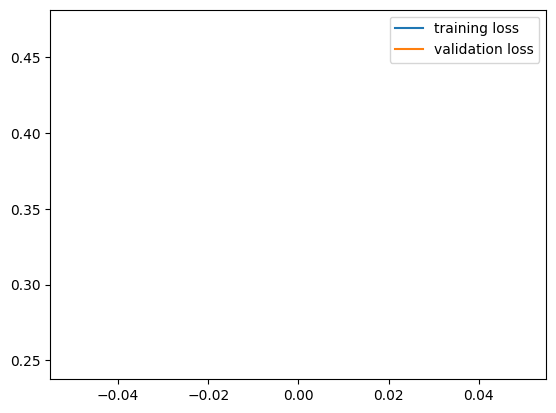

Train Epoch: 1 loss: 3.19591
Train Epoch: 1 loss: 2.95374
Train Epoch: 1 loss: 3.30930

Validation set: Average loss: 0.50498


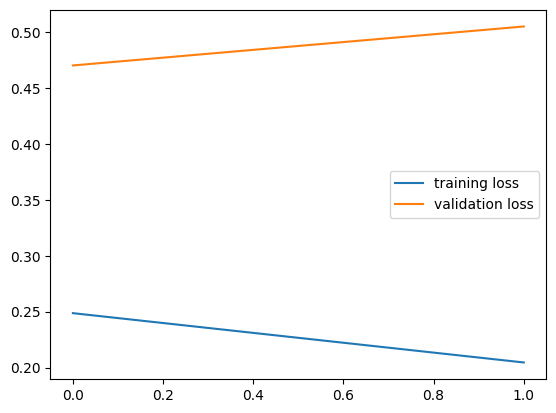

KeyboardInterrupt: 

In [12]:
losses = {"train": [], "val": []}
for epoch in range(20):

    train_loss = train(epoch, criterion, model, optimizer, train_dataloader, vocab_size_train, device)
    val_loss = validate(criterion, model, val_dataloader, vocab_size_train, vocab_train_df, device)
    losses["train"].append(train_loss)
    losses["val"].append(val_loss)
    
    plt.plot(losses["train"], label="training loss")
    plt.plot(losses["val"], label="validation loss")

    plt.legend()
    plt.pause(0.000001)
    plt.show()

In [ ]:

'''
def main():

    num_epochs = 20
    print_every = 500

    for epoch in range(1,num_epochs+1):   
        for idx, (image, captions) in enumerate(iter(train_dataloader)):
            image,captions = image.to(device),captions.to(device)

            # Zero the gradients.
            optimizer.zero_grad()

            # Feed forward
            outputs = model(image, captions)
            
            # Calculate the batch loss.
            loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))

            
            # Backward pass.
            loss.backward()

            # Update the parameters in the optimizer.
            optimizer.step()
            
            if (idx+1)%print_every == 0:
                print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
                
                
                #generate the caption
                model.eval()
                with torch.no_grad():
                    dataiter = iter(train_dataloader)
                    img,_ = next(dataiter)
                    features = model.encoder(img[0:1].to(device))
                    print(f"features shape - {features.shape}")
                    caps = model.decoder.generate_caption(features.unsqueeze(0),vocab=vocab_train_df)
                    caption = ' '.join(caps)
                    print(caption)
                    show_image(img[0],title=caption)
                    
                model.train()
                
if __name__ == "__main__":
    main()
'''

THE LOSS VALUES CAN BE IMPROVED SETTING BATCH SIZE TO 8 AND PRINT_EVERY = 1000 OR BATCH SIZE = 4 AND PRINT_EVERY = 2000. HOWEVER, WE WILL OBTAIN MORE MUCH UNKNOWN TOKENS IN OUR GENERATED CAPTIONS. AS WE HAVE INCREASED THE BATCH SIZE TO 16 WE CAN TRY ALSO TO INCREASE A LITTLE BIT THE LEARNING RATE TTO OBTAIN BETTER LOSS